### **Chunk 6: Pipelines - The Professional Way**

#### **1. Concept Introduction**

A scikit-learn `Pipeline` chains together multiple steps (transformers and a final estimator) into one object. When you call `.fit()` on a pipeline, it intelligently calls `.fit_transform()` on each transformer in sequence on your training data, passing the output of one step as the input to the next, and finally calls `.fit()` on the last step (your model).

When you call `.predict()` or `.score()` on a fitted pipeline, it automatically calls `.transform()` on all the transformers before making a prediction.

**Why is this a game-changer?**

1.  **Prevents Data Leakage (The #1 Reason)**: It makes it *impossible* to make the most common mistake in preprocessing: fitting your scaler or imputer on the test set. The pipeline guarantees that `.fit()` is only ever called on the data you pass to the pipeline's `fit` method (i.e., your training data). This is the single most important concept for robust model validation.
2.  **Convenience and Simplicity**: You go from a dozen lines of fitting, transforming, and predicting to just two: `pipeline.fit(X_train, y_train)` and `pipeline.predict(X_test)`. Your code becomes dramatically cleaner and more readable.
3.  **Grid Search and Automation**: When we get to hyperparameter tuning, you can't tune the model and the preprocessor separately. A pipeline allows you to treat the entire workflow as a single object, so you can tune things like `imputer__strategy` and `model__C` at the same time.

For datasets with mixed data types (e.g., numbers and text), we use `ColumnTransformer` inside the pipeline. This is a brilliant tool that lets you apply different preprocessing steps to different columns.

#### **2. Dataset EDA: Adult Income Dataset**

This dataset from the UCI Machine Learning Repository is a perfect challenge. The goal is to predict whether an individual earns more than $50,000 a year based on census data. It contains a mix of numerical features (like `age`, `hours-per-week`) and categorical features (like `workclass`, `education`, `native-country`).

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

# Set plot style
sns.set_style('whitegrid')

**Load Data**

In [2]:
adult = fetch_openml(name='adult',
                     version=2,
                     as_frame=True,
                     parser='auto')
df = adult.frame
print(df.head())
# The target is 'class'. Let's rename it and convert it to 0 / 1
df['income_>50k'] = (df['class'] == '>50K').astype(int)
df = df.drop('class', axis=1)

   age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18        NaN  103497  Some-college             10       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                NaN    Own-child  White  Female             0             0   

   hours-per-week native-country  class  
0       

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_>50k
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  income_>50k     48842 non-null  int64   
dtypes: category(8), int64(7)
memory usage: 3.0 MB


**Clean Missing Values**
> In this dataset, missing values are denoted by '?'. Let's replace them with NaN

In [6]:
df.replace('?', np.nan, inplace=True)

df.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income_>50k          0
dtype: int64

**Basic Statistics**

In [8]:
# Numerical Statistics
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income_>50k
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382,0.239282
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444,0.426649
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [9]:
# Categorical Statistics
df.describe(include=['category', 'object'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,46043,48842,48842,46033,48842,48842,48842,47985
unique,8,16,7,14,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,33906,15784,22379,6172,19716,41762,32650,43832


**Target Variable Distribution**

income_>50k
0    0.760718
1    0.239282
Name: proportion, dtype: float64


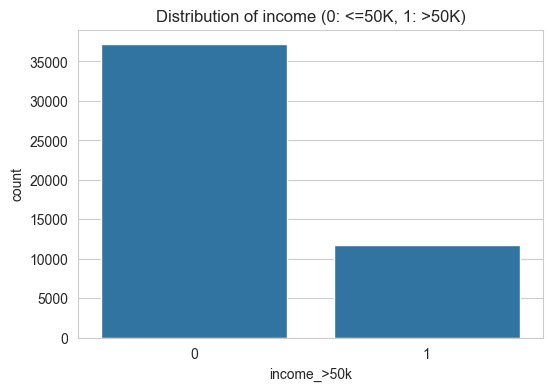

Hmmmm. we have an imbalanced dataset here. (approx 76% vs 24%)
More People are making less than 50k annually


In [15]:
print(df['income_>50k'].value_counts(normalize=True))
plt.figure(figsize=(6, 4))
sns.countplot(x = 'income_>50k', data=df)
plt.title('Distribution of income (0: <=50K, 1: >50K)')
plt.show()
print("Hmmmm. we have an imbalanced dataset here. (approx 76% vs 24%)\nMore People are making less than 50k annually")

**Categorical Feature Plot**

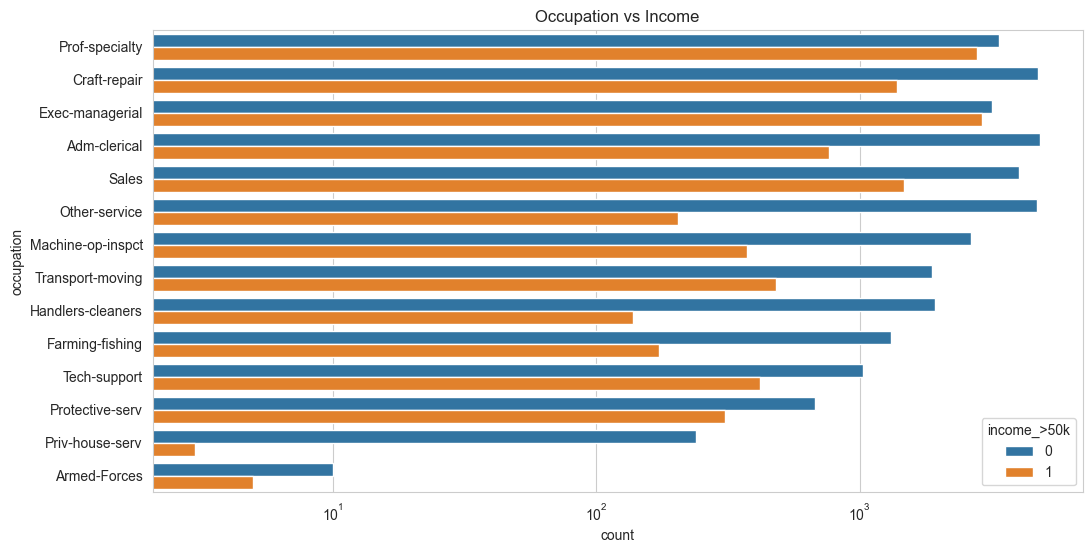

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df,
    y='occupation',
    order=df['occupation'].value_counts().index,
    hue='income_>50k'
)
plt.title('Occupation vs Income')
plt.xscale('log') # Use a log scale due to large differences in counts
plt.show()

#### **3. Minimal Working Example: The Full Pipeline**

Now let's build a professional pipeline to handle this mixed-type data.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Seperation
X = df.drop('income_>50k', axis=1)
y = df['income_>50k']

X_train, X_test, y_train, y_test = \
                          train_test_split(
                              X,
                              y,
                              test_size=0.2,
                              random_state=42,
                              stratify=y
                          )
# Sanity check on shapes
print(f"Shape of X_Train : {X_train.shape}")
print(f"Shape of X_Test : {X_test.shape}")
print(f"Shape of y_Train : {y_train.shape}")
print(f"Shape of y_Test : {y_test.shape}")

Shape of X_Train : (39073, 14)
Shape of X_Test : (9769, 14)
Shape of y_Train : (39073,)
Shape of y_Test : (9769,)


**Identify column types**
> As we saw in our `df.info()`, Some Features were categorical and some were numerical.
BUT..... everything needs to numerical. 
Let's fix that

In [20]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['category',
                                                'object']).columns.tolist()
print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

Numeric features: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


##### **Create the preprocessing pipelines for each data type**
> Pipeline for numeric features: impute missing values with the median, then scale.

In [21]:
numeric_transformer = Pipeline(
    steps=[
        (
            'imputer', SimpleImputer(strategy='median')
        ),
        (
            'scaler', StandardScaler()
        )
    ]
)

> Pipeline for categorical features: impute missing with the most frequent, then one-hot-encode

In [23]:
categorical_transformer = Pipeline(
    [
        (
            'imputer', SimpleImputer(strategy='most_frequent')
        ),
        (
            'onehot', OneHotEncoder(handle_unknown='ignore') # 'handle_unknown' is crucial for production
        )
    ]
)

**Create the master preprocessor with ColumnTransformer**

In [24]:
# This object applies the correct transformer to the correct columns
preprocessor = ColumnTransformer(
    transformers=\
        [
            (
                  'num', numeric_transformer, numeric_features  
            ),
            (
                'cat', categorical_transformer, categorical_features
            )
        ],
    remainder= 'passthrough' # Keep other columns if any (none in this case)
)

#### NOW Creating the full pipeline with preprocessor and model

In [25]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42,
                                      max_iter=1000))
])
full_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### So beautiful
> Let's Train and evaluate the ENTIRE pipeline in one go!

In [26]:
# We fit on the original, un-processed X_train. The pipeline handles the rest
full_pipeline.fit(X_train, y_train)

# Score on the original, unprocessed X_test
accuracy = full_pipeline.score(X_test, y_test)
print(f"\nPipeline Accuracy: {accuracy*100:.2f}%")


Pipeline Accuracy: 85.24%


#### **4. Inspecting the pipeline**
> We can still access the components of the fitted pipeline

In [27]:
# Get the final model's coefficients
final_model = full_pipeline.named_steps['classifier']
print(f"Model intercept: {final_model.intercept_}")

Model intercept: [-1.56687608]


**Getting feature names after one-hot encoding is tricky but essential**
> This is a key piece of practical knowledge

In [29]:
ohe_features = full_pipeline.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .named_steps['onehot']\
    .get_feature_names_out(categorical_features)
# Combine with numeric features to get all final feature names
all_feature_names = numeric_features + list(ohe_features)

# Create a DataFrame of coefficients
coeffs = pd.DataFrame(
    data = final_model.coef_.T,
    index=all_feature_names,
    columns=['coefficient']
).sort_values('coefficient', ascending=False)

print("Top 10 positive Coefficients")
print(coeffs.head(10))

print("Top 10 Negative Coefficients")
print(coeffs.tail(10))

Top 10 positive Coefficients
                                   coefficient
capital-gain                          2.266560
marital-status_Married-civ-spouse     1.662327
marital-status_Married-AF-spouse      1.284302
native-country_France                 0.904712
native-country_England                0.901708
occupation_Exec-managerial            0.803640
education-num                         0.735635
native-country_Ireland                0.734024
relationship_Wife                     0.721432
native-country_Cambodia               0.709139
Top 10 Negative Coefficients
                                   coefficient
relationship_Own-child               -0.819657
occupation_Other-service             -0.861709
relationship_Other-relative          -0.907951
sex_Female                           -0.916386
occupation_Farming-fishing           -0.933690
native-country_Dominican-Republic    -0.987674
native-country_South                 -1.126642
marital-status_Never-married         -1.242189
oc

#### **5. Common Pitfalls**

1.  **Preprocessing Before Splitting**: The classic mistake. With pipelines, you are forced to do it the right way: pass the raw, original `X_train` and `X_test` to the pipeline. Let the pipeline manage the transformations internally.
2.  **Forgetting `handle_unknown='ignore'`**: If your `OneHotEncoder` sees a new category in the test set that wasn't in the training set (e.g., a new 'occupation'), it will throw an error. Setting `handle_unknown='ignore'` tells it to create a row of all zeros for that feature, which is the correct and robust way to handle this.
3.  **Leaking Column Names**: Using column indices (`[0, 3, 5]`) instead of column names in the `ColumnTransformer` is fragile. If the column order changes, your pipeline breaks. Always use names for robustness.

# Amazing progress. I love your ambition and dedication. I hope you achieve greatness in life.

### Proceed to Chunk 07 : Cross-Validation & Hyperparameter Tuning